In [2]:
import ee
import geemap
import logging
import multiprocessing
import os
import torch
import pandas as pd
from skimage.measure.entropy import shannon_entropy
import numpy as np
import re
import rasterio
import matplotlib.pyplot as plt
import json
from utils.functions import getResult, getRequests, get_files_info
from sklearn.mixture import GaussianMixture

GEE_PROJECT_ID = "fusion-371234"
ee.Authenticate()
ee.Initialize(project=GEE_PROJECT_ID)

# Dataset

In [ ]:
Map = geemap.Map()
#The study area is in the district of Ejura-Sekyedumase, located in the northern part of
#the Ashanti Region of Ghana and situated within longitudes 1°5 W and 1°39’ W and latitudes
#7°9’ N and 7°36’ N
Map = geemap.Map(center=[7.375, -1.3667], zoom=20)
Map.add_basemap("HYBRID")
Map

In [ ]:
# Convert to GeoJSON format
geojson_dict = Map.user_roi.getInfo()

# Save to file
with open("ejura.json", "w") as f:
    json.dump(geojson_dict, f)

print("✅ Region saved as ejura.json")

## L8

In [ ]:
LANDSAT_COLLECTION_ID = "LANDSAT/LC08/C02/T1_L2"

# Landsat 8 Surface Reflectance band names (common)
selected_bands = [
    "SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7",  # Optical SR
]

CLOUD_FILTER = 20
PROCESSES = multiprocessing.cpu_count() - 1
dimensions = "256x256"
buffer = (int(dimensions.split('x')[0]) / 2) * 30   # Landsat = 30 m resolution
crs = "EPSG:4326"
num_samples = 4
DATE = ["2017-01-01", "2018-01-01"]
with open("ejura.json", "r") as f:
    region_data = json.load(f)

# Convert to Earth Engine Geometry
region = ee.Geometry(region_data)

with open("ejura.json", "r") as f:
    region_data = json.load(f)


params = {
    "count": num_samples,
    "buffer": buffer,
    "scale": 30,                   \
    "bands": None,
    "seed": 1,
    "dimensions": dimensions,
    "format": "GEO_TIFF",
    "prefix": "sample_",
    "processes": min(25, PROCESSES),
    "out_dir": "l8_ejura_2017_2018",
    "crs": crs,
}

landsat_col = ee.ImageCollection(LANDSAT_COLLECTION_ID).filterBounds(region).filterDate(DATE[0], DATE[1])

params['bands'] = [{
    'id': band, 
    'scale': 30,
    'crs': params['crs']} for band in selected_bands]


## Sentinel-2

In [10]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"
selected_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
CLOUD_FILTER = 100
PROCESSES = multiprocessing.cpu_count() - 1
dimensions = "256x256"
buffer = (int(dimensions.split('x')[0]) / 2) * 10 
crs = "EPSG:4326"
num_samples = 1
DATE = ["2017-01-01", "2020-01-01"]
with open("ejura.json", "r") as f:
    region_data = json.load(f)

# Convert to Earth Engine Geometry
region = ee.Geometry(region_data)

params = {
    "count": num_samples,  # How many image sample points to export
    "buffer": buffer,  # The buffer distance (m) around each point
    "scale": 10,  # The scale to do stratified sampling
    "bands": None, # The bands to export
    "seed": 1,  # A randomization seed to use for subsampling.
    "dimensions": dimensions,  # The dimension of each image chip
    "format": "GEO_TIFF",  # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
    "prefix": "sample_",  # The filename prefix
    "processes": min(25, PROCESSES),  # How many processes to used for parallel processing
    "out_dir": "s2_ejura_2017_2020",  # The output directory. Default to the current working directly
    "crs": crs,  # The CRS to use for the output image
}

s2_sr_col = ee.ImageCollection(S2_SR_COLLECTION_ID).filterBounds(region).filterDate(DATE[0], DATE[1]).filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))


params['bands'] = [{
    'id': band, 
    'scale': (
        10 if band in ['B2', 'B3', 'B4', 'B8'] else 
        20 if band in ['B5', 'B6', 'B7', 'B8A', 'B11', 'B12'] else 
        60
    ), 
    'crs': params['crs']} for band in selected_bands]


In [11]:
images = []
samples = []
col_size = s2_sr_col.size().getInfo()
print(f"Number of images: {col_size}")
for i in range(col_size):
    sr_img = s2_sr_col.toList(s2_sr_col.size()).getInfo()[i]
    id = sr_img['properties']['PRODUCT_ID']
    sr_img = s2_sr_col.filter(ee.Filter.eq("PRODUCT_ID", id)).first()
    sr_img = sr_img.select(selected_bands)
    images.append(sr_img)
    samples.append(id)

os.makedirs(params['out_dir'], exist_ok=True)
for i in range(len(images)):
    image = images[i]
    id = samples[i]
    logging.basicConfig()
    items = getRequests(params, image, region)
    pool = multiprocessing.Pool(params["processes"])
    pool.starmap(getResult, [(index, item, image, params, id) for index, item in enumerate(items)])
    pool.close()      

Number of images: 194
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170107_S2A_MSIL1C_20170107T102401_N0500_R065_T30NXP_20231026T042433_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170127_S2A_MSIL1C_20170127T102301_N0204_R065_T30NXP_20170127T103137_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170206_S2A_MSIL1C_20170206T102211_N0204_R065_T30NXP_20170206T102733_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170216_S2A_MSIL1C_20170216T102101_N0204_R065_T30NXP_20170216T103427_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170226_S2A_MSIL1C_20170226T102021_N0204_R065_T30NXP_20170226T103718_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170308_S2A_MSIL1C_20170308T102021_N0204_R065_T30NXP_20170308T103738_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170318_S2A_MSIL1C_20170318T102011_N0204_R065_T30NXP_20170318T102933_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170328_S2A_MSIL1C_20170328T102021_N0204_R065_T30NXP_20170328T102821_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170407_S2A_MSIL1C_20170407T102021_N0204_R065_T30NXP_20170407T103606_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170417_S2A_MSIL1C_20170417T102021_N0204_R065_T30NXP_20170417T103557_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170427_S2A_MSIL1C_20170427T102031_N0205_R065_T30NXP_20170427T102959_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170507_S2A_MSIL1C_20170507T102031_N0205_R065_T30NXP_20170507T103542_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170517_S2A_MSIL1C_20170517T102031_N0205_R065_T30NXP_20170517T103615_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170606_S2A_MSIL1C_20170606T102031_N0205_R065_T30NXP_20170606T103719_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170616_S2A_MSIL1C_20170616T102021_N0205_R065_T30NXP_20170616T103554_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170626_S2A_MSIL1C_20170626T102021_N0205_R065_T30NXP_20170626T103545_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170701_S2B_MSIL1C_20170701T102029_N0205_R065_T30NXP_20170701T103510_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170706_S2A_MSIL1C_20170706T102021_N0205_R065_T30NXP_20170706T103524_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170711_S2B_MSIL1C_20170711T102029_N0205_R065_T30NXP_20170711T103532_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170716_S2A_MSIL1C_20170716T102021_N0205_R065_T30NXP_20170716T103548_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170721_S2B_MSIL1C_20170721T102029_N0205_R065_T30NXP_20170721T103554_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170726_S2A_MSIL1C_20170726T102021_N0205_R065_T30NXP_20170726T103522_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170805_S2A_MSIL1C_20170805T102031_N0205_R065_T30NXP_20170805T103758_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170815_S2A_MSIL1C_20170815T102021_N0205_R065_T30NXP_20170815T103736_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170820_S2B_MSIL1C_20170820T102019_N0205_R065_T30NXP_20170820T103609_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170825_S2A_MSIL1C_20170825T102021_N0205_R065_T30NXP_20170825T103338_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170830_S2B_MSIL1C_20170830T102019_N0205_R065_T30NXP_20170830T103754_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170904_S2A_MSIL1C_20170904T102021_N0205_R065_T30NXP_20170904T103734_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170909_S2B_MSIL1C_20170909T102019_N0205_R065_T30NXP_20170909T103814_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170914_S2A_MSIL1C_20170914T102021_N0205_R065_T30NXP_20170914T103822_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170919_S2B_MSIL1C_20170919T102009_N0205_R065_T30NXP_20170919T103821_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170924_S2A_MSIL1C_20170924T102021_N0205_R065_T30NXP_20170924T102649_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20170929_S2B_MSIL1C_20170929T102009_N0205_R065_T30NXP_20170929T102752_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171004_S2A_MSIL1C_20171004T102021_N0205_R065_T30NXP_20171004T102926_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171009_S2B_MSIL1C_20171009T102009_N0205_R065_T30NXP_20171009T102938_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171014_S2A_MSIL1C_20171014T102021_N0205_R065_T30NXP_20171014T103459_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171019_S2B_MSIL1C_20171019T102019_N0205_R065_T30NXP_20171019T103253_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171024_S2A_MSIL1C_20171024T102111_N0206_R065_T30NXP_20171024T154112_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171029_S2B_MSIL1C_20171029T102119_N0206_R065_T30NXP_20171029T153818_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171103_S2A_MSIL1C_20171103T102201_N0206_R065_T30NXP_20171106T195236_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171108_S2B_MSIL1C_20171108T102219_N0206_R065_T30NXP_20171108T171959_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171113_S2A_MSIL1C_20171113T102251_N0206_R065_T30NXP_20171113T140121_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171118_S2B_MSIL1C_20171118T102309_N0206_R065_T30NXP_20171118T153818_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171123_S2A_MSIL1C_20171123T102331_N0206_R065_T30NXP_20171123T140346_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171128_S2B_MSIL1C_20171128T102349_N0206_R065_T30NXP_20171128T123449_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171203_S2A_MSIL1C_20171203T102401_N0206_R065_T30NXP_20171203T135308_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171208_S2B_MSIL1C_20171208T102359_N0206_R065_T30NXP_20171208T140517_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171218_S2B_MSIL1C_20171218T102419_N0206_R065_T30NXP_20171218T122931_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171223_S2A_MSIL1C_20171223T102431_N0206_R065_T30NXP_20171223T140038_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20171228_S2B_MSIL1C_20171228T102429_N0500_R065_T30NXP_20230806T221528_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180102_S2A_MSIL1C_20180102T102421_N0500_R065_T30NXP_20230801T100953_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180107_S2B_MSIL1C_20180107T102359_N0206_R065_T30NXP_20180107T122959_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180112_S2A_MSIL1C_20180112T102401_N0206_R065_T30NXP_20180112T153609_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180117_S2B_MSIL1C_20180117T102339_N0206_R065_T30NXP_20180117T140447_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180122_S2A_MSIL1C_20180122T102321_N0500_R065_T30NXP_20230805T134106_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180127_S2B_MSIL1C_20180127T102259_N0500_R065_T30NXP_20230805T195500_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180201_S2A_MSIL1C_20180201T102241_N0206_R065_T30NXP_20180201T154521_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180206_S2B_MSIL1C_20180206T102209_N0206_R065_T30NXP_20180206T154410_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180211_S2A_MSIL1C_20180211T102141_N0206_R065_T30NXP_20180211T171719_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180216_S2B_MSIL1C_20180216T102059_N0206_R065_T30NXP_20180216T153448_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180221_S2A_MSIL1C_20180221T102031_N0206_R065_T30NXP_20180221T155336_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180226_S2B_MSIL1C_20180226T102019_N0206_R065_T30NXP_20180226T171749_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180303_S2A_MSIL1C_20180303T102021_N0206_R065_T30NXP_20180303T154452_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180308_S2B_MSIL1C_20180308T102019_N0206_R065_T30NXP_20180308T140416_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180313_S2A_MSIL1C_20180313T102021_N0206_R065_T30NXP_20180313T153719_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180318_S2B_MSIL1C_20180318T102019_N0206_R065_T30NXP_20180318T130454_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180323_S2A_MSIL1C_20180323T102021_N0500_R065_T30NXP_20230904T201946_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180328_S2B_MSIL1C_20180328T102019_N0206_R065_T30NXP_20180328T155221_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180402_S2A_MSIL1C_20180402T102021_N0206_R065_T30NXP_20180402T171901_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180407_S2B_MSIL1C_20180407T102019_N0206_R065_T30NXP_20180407T155357_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180412_S2A_MSIL1C_20180412T102021_N0206_R065_T30NXP_20180412T123033_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180417_S2B_MSIL1C_20180417T102019_N0206_R065_T30NXP_20180417T155212_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180422_S2A_MSIL1C_20180422T102031_N0206_R065_T30NXP_20180422T154603_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180427_S2B_MSIL1C_20180427T102019_N0206_R065_T30NXP_20180427T130607_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180502_S2A_MSIL1C_20180502T102031_N0206_R065_T30NXP_20180502T172530_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180507_S2B_MSIL1C_20180507T102019_N0206_R065_T30NXP_20180507T140831_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180512_S2A_MSIL1C_20180512T102031_N0206_R065_T30NXP_20180512T160357_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180517_S2B_MSIL1C_20180517T102019_N0206_R065_T30NXP_20180517T140800_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180522_S2A_MSIL1C_20180522T102031_N0206_R065_T30NXP_20180522T140632_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180601_S2A_MSIL1C_20180601T102021_N0206_R065_T30NXP_20180601T140121_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180606_S2B_MSIL1C_20180606T102019_N0206_R065_T30NXP_20180606T190247_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180611_S2A_MSIL1C_20180611T102021_N0206_R065_T30NXP_20180611T150758_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180616_S2B_MSIL1C_20180616T102019_N0206_R065_T30NXP_20180616T172531_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180621_S2A_MSIL1C_20180621T102021_N0206_R065_T30NXP_20180621T154445_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180626_S2B_MSIL1C_20180626T102019_N0206_R065_T30NXP_20180626T135626_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180701_S2A_MSIL1C_20180701T102021_N0206_R065_T30NXP_20180701T140000_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180706_S2B_MSIL1C_20180706T102019_N0206_R065_T30NXP_20180706T140932_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180711_S2A_MSIL1C_20180711T102021_N0206_R065_T30NXP_20180711T154916_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180716_S2B_MSIL1C_20180716T102019_N0206_R065_T30NXP_20180716T171740_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180721_S2A_MSIL1C_20180721T102021_N0206_R065_T30NXP_20180721T141045_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180726_S2B_MSIL1C_20180726T102019_N0206_R065_T30NXP_20180726T155911_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180731_S2A_MSIL1C_20180731T102021_N0206_R065_T30NXP_20180731T141232_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180805_S2B_MSIL1C_20180805T102019_N0206_R065_T30NXP_20180805T160757_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180810_S2A_MSIL1C_20180810T102021_N0206_R065_T30NXP_20180810T160724_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180815_S2B_MSIL1C_20180815T102019_N0206_R065_T30NXP_20180815T173756_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180820_S2A_MSIL1C_20180820T102021_N0206_R065_T30NXP_20180820T160610_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180825_S2B_MSIL1C_20180825T102019_N0206_R065_T30NXP_20180825T161751_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180830_S2A_MSIL1C_20180830T102021_N0206_R065_T30NXP_20180830T140859_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180904_S2B_MSIL1C_20180904T102019_N0206_R065_T30NXP_20180904T155618_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180909_S2A_MSIL1C_20180909T102021_N0206_R065_T30NXP_20180909T173432_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180914_S2B_MSIL1C_20180914T102019_N0206_R065_T30NXP_20180914T173602_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180919_S2A_MSIL1C_20180919T102021_N0206_R065_T30NXP_20180919T142010_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180924_S2B_MSIL1C_20180924T102019_N0206_R065_T30NXP_20180924T192539_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20180929_S2A_MSIL1C_20180929T102021_N0206_R065_T30NXP_20180929T123329_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181004_S2B_MSIL1C_20181004T102019_N0206_R065_T30NXP_20181004T154725_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181009_S2A_MSIL1C_20181009T102021_N0206_R065_T30NXP_20181009T154012_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181014_S2B_MSIL1C_20181014T102019_N0206_R065_T30NXP_20181014T172055_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181019_S2A_MSIL1C_20181019T102031_N0206_R065_T30NXP_20181019T123504_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181024_S2B_MSIL1C_20181024T102059_N0206_R065_T30NXP_20181024T172336_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181029_S2A_MSIL1C_20181029T102131_N0206_R065_T30NXP_20181029T123012_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181103_S2B_MSIL1C_20181103T102159_N0206_R065_T30NXP_20181103T135920_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181108_S2A_MSIL1C_20181108T102231_N0207_R065_T30NXP_20181108T122729_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181118_S2A_MSIL1C_20181118T102311_N0207_R065_T30NXP_20181118T121956_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181123_S2B_MSIL1C_20181123T102339_N0207_R065_T30NXP_20181123T135926_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181128_S2A_MSIL1C_20181128T102351_N0207_R065_T30NXP_20181128T122909_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181203_S2B_MSIL1C_20181203T102359_N0207_R065_T30NXP_20181203T185431_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181208_S2A_MSIL1C_20181208T102401_N0207_R065_T30NXP_20181208T120647_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181213_S2B_MSIL1C_20181213T102419_N0207_R065_T30NXP_20181213T123421_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181218_S2A_MSIL1C_20181218T102431_N0207_R065_T30NXP_20181218T111403_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181223_S2B_MSIL1C_20181223T102429_N0207_R065_T30NXP_20181223T135310_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20181228_S2A_MSIL1C_20181228T102431_N0207_R065_T30NXP_20181228T111345_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190102_S2B_MSIL1C_20190102T102429_N0207_R065_T30NXP_20190102T122648_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190107_S2A_MSIL1C_20190107T102411_N0207_R065_T30NXP_20190107T121719_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190112_S2B_MSIL1C_20190112T102409_N0207_R065_T30NXP_20190112T135302_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190117_S2A_MSIL1C_20190117T102351_N0207_R065_T30NXP_20190117T123302_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190122_S2B_MSIL1C_20190122T102329_N0207_R065_T30NXP_20190122T153243_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190127_S2A_MSIL1C_20190127T102311_N0207_R065_T30NXP_20190127T135810_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190201_S2B_MSIL1C_20190201T102249_N0207_R065_T30NXP_20190201T123206_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190206_S2A_MSIL1C_20190206T102211_N0207_R065_T30NXP_20190206T122851_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190211_S2B_MSIL1C_20190211T102149_N0207_R065_T30NXP_20190211T153513_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190216_S2A_MSIL1C_20190216T102111_N0207_R065_T30NXP_20190216T123123_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190221_S2B_MSIL1C_20190221T102039_N0207_R065_T30NXP_20190221T171353_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190226_S2A_MSIL1C_20190226T102021_N0207_R065_T30NXP_20190226T154627_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190303_S2B_MSIL1C_20190303T102019_N0207_R065_T30NXP_20190303T184358_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190308_S2A_MSIL1C_20190308T102021_N0207_R065_T30NXP_20190308T154224_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190313_S2B_MSIL1C_20190313T102019_N0207_R065_T30NXP_20190313T171619_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190318_S2A_MSIL1C_20190318T102021_N0207_R065_T30NXP_20190318T154039_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190323_S2B_MSIL1C_20190323T102029_N0207_R065_T30NXP_20190323T153940_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190328_S2A_MSIL1C_20190328T102021_N0207_R065_T30NXP_20190328T172042_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190402_S2B_MSIL1C_20190402T102029_N0207_R065_T30NXP_20190402T140245_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190407_S2A_MSIL1C_20190407T102021_N0207_R065_T30NXP_20190407T135527_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190412_S2B_MSIL1C_20190412T102029_N0207_R065_T30NXP_20190412T140052_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190417_S2A_MSIL1C_20190417T102031_N0207_R065_T30NXP_20190417T122849_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190422_S2B_MSIL1C_20190422T102029_N0207_R065_T30NXP_20190422T140447_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190427_S2A_MSIL1C_20190427T102031_N0207_R065_T30NXP_20190427T123429_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190502_S2B_MSIL1C_20190502T102029_N0207_R065_T30NXP_20190502T140014_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190507_S2A_MSIL1C_20190507T102031_N0207_R065_T30NXP_20190507T135802_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190512_S2B_MSIL1C_20190512T102029_N0207_R065_T30NXP_20190512T130653_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190517_S2A_MSIL1C_20190517T102031_N0207_R065_T30NXP_20190517T122751_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190527_S2A_MSIL1C_20190527T102031_N0207_R065_T30NXP_20190527T153940_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190601_S2B_MSIL1C_20190601T102029_N0207_R065_T30NXP_20190601T130311_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190606_S2A_MSIL1C_20190606T102031_N0207_R065_T30NXP_20190606T135541_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190611_S2B_MSIL1C_20190611T102029_N0207_R065_T30NXP_20190611T140241_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190616_S2A_MSIL1C_20190616T102031_N0207_R065_T30NXP_20190616T153536_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190621_S2B_MSIL1C_20190621T102029_N0207_R065_T30NXP_20190621T130753_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190626_S2A_MSIL1C_20190626T102031_N0207_R065_T30NXP_20190626T123312_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190701_S2B_MSIL1C_20190701T102029_N0207_R065_T30NXP_20190701T130750_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190706_S2A_MSIL1C_20190706T102031_N0207_R065_T30NXP_20190706T135616_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190711_S2B_MSIL1C_20190711T102029_N0208_R065_T30NXP_20190711T140413_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190716_S2A_MSIL1C_20190716T102031_N0208_R065_T30NXP_20190716T124049_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190721_S2B_MSIL1C_20190721T102029_N0208_R065_T30NXP_20190721T130541_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190726_S2A_MSIL1C_20190726T102031_N0208_R065_T30NXP_20190726T135328_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190731_S2B_MSIL1C_20190731T102029_N0208_R065_T30NXP_20190731T153938_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190805_S2A_MSIL1C_20190805T102031_N0208_R065_T30NXP_20190805T135523_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190810_S2B_MSIL1C_20190810T102029_N0208_R065_T30NXP_20190810T140301_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190815_S2A_MSIL1C_20190815T102031_N0208_R065_T30NXP_20190815T172428_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190820_S2B_MSIL1C_20190820T102029_N0208_R065_T30NXP_20190820T135529_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190825_S2A_MSIL1C_20190825T102031_N0208_R065_T30NXP_20190825T135628_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190830_S2B_MSIL1C_20190830T102029_N0208_R065_T30NXP_20190830T135711_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190904_S2A_MSIL1C_20190904T102021_N0208_R065_T30NXP_20190904T140049_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190909_S2B_MSIL1C_20190909T102029_N0208_R065_T30NXP_20190909T153237_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190914_S2A_MSIL1C_20190914T102021_N0208_R065_T30NXP_20190914T135715_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190919_S2B_MSIL1C_20190919T102019_N0208_R065_T30NXP_20190919T131240_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190924_S2A_MSIL1C_20190924T102021_N0208_R065_T30NXP_20190924T121358_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20190929_S2B_MSIL1C_20190929T102029_N0208_R065_T30NXP_20190929T135446_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191004_S2A_MSIL1C_20191004T102031_N0208_R065_T30NXP_20191004T135450_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191009_S2B_MSIL1C_20191009T102029_N0208_R065_T30NXP_20191009T171608_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191014_S2A_MSIL1C_20191014T102031_N0208_R065_T30NXP_20191014T123400_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191019_S2B_MSIL1C_20191019T102029_N0208_R065_T30NXP_20191019T131448_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191024_S2A_MSIL1C_20191024T102111_N0208_R065_T30NXP_20191024T111557_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191029_S2B_MSIL1C_20191029T102039_N0208_R065_T30NXP_20191029T130137_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191103_S2A_MSIL1C_20191103T102211_N0208_R065_T30NXP_20191103T121858_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191108_S2B_MSIL1C_20191108T102139_N0208_R065_T30NXP_20191108T130547_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191113_S2A_MSIL1C_20191113T102301_N0208_R065_T30NXP_20191113T111558_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191118_S2B_MSIL1C_20191118T102219_N0208_R065_T30NXP_20191118T121704_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191123_S2A_MSIL1C_20191123T102341_N0208_R065_T30NXP_20191123T111823_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191128_S2B_MSIL1C_20191128T102259_N0208_R065_T30NXP_20191128T121533_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191203_S2A_MSIL1C_20191203T102401_N0208_R065_T30NXP_20191204T152928_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191208_S2B_MSIL1C_20191208T102319_N0208_R065_T30NXP_20191208T123223_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191213_S2A_MSIL1C_20191213T102421_N0208_R065_T30NXP_20191213T111646_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191218_S2B_MSIL1C_20191218T102339_N0208_R065_T30NXP_20191218T121239_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191223_S2A_MSIL1C_20191223T102431_N0208_R065_T30NXP_20191223T111855_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2017_2020/20191228_S2B_MSIL1C_20191228T102339_N0208_R065_T30NXP_20191228T121650_sample_0.tif


Total number of files: 193
Found 193 matching images.


/tmp/ipykernel_86891/2070535858.py:43: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  plt.rcParams['toolbar'] = 'toolmanager'


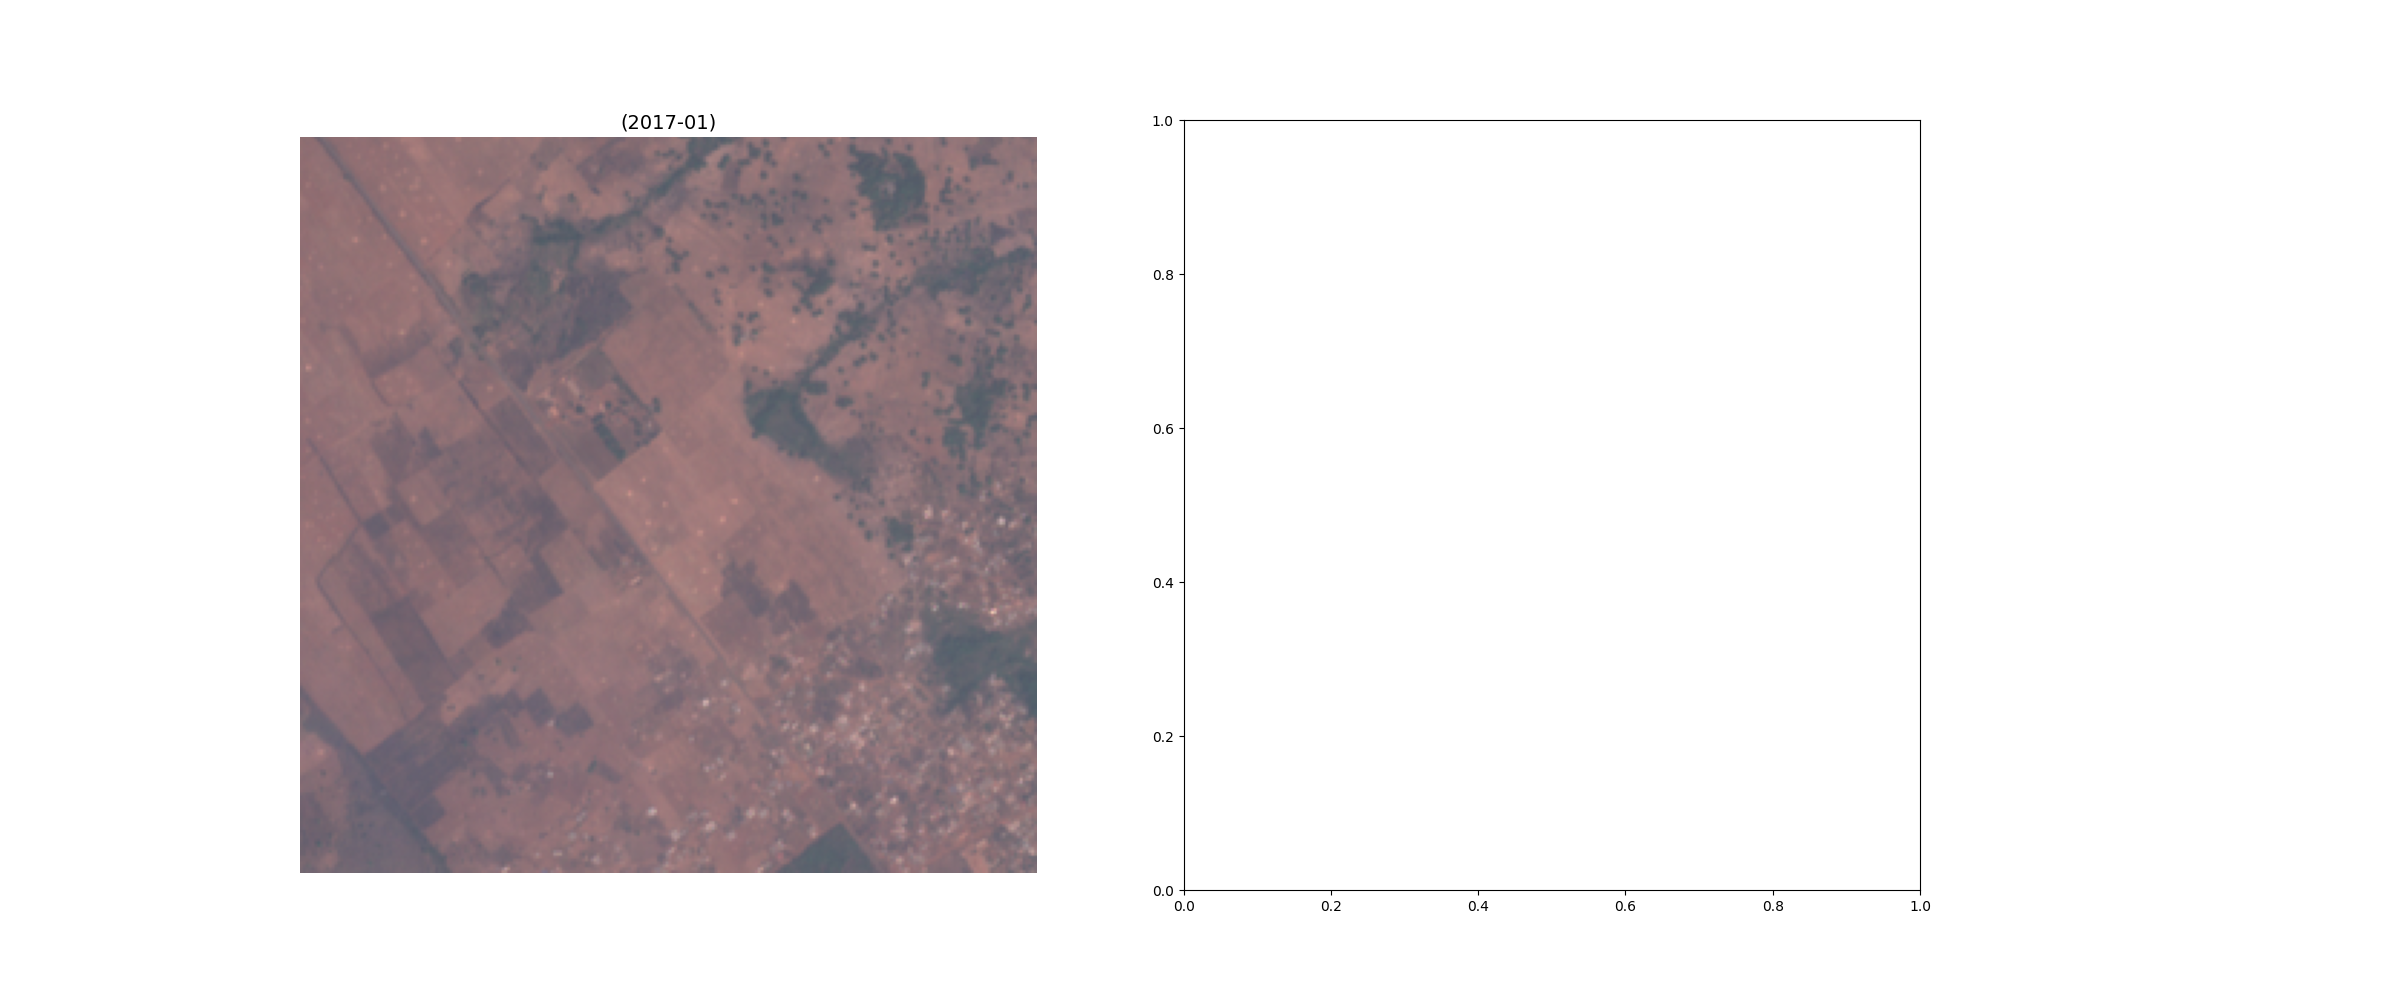

In [13]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
import re
from datetime import datetime
import matplotlib.dates as mdates

scale = 3000
sample_point = "0"
# OUTDIR = "s2_ejura_2017_2018"
OUTDIR = "s2_ejura_2017_2020"

n_files, name_files = get_files_info(OUTDIR)
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

file_paths = []
dates = []
for f in matching_files:
    file_paths.append(os.path.join(OUTDIR, f))
    match = re.search(r"_(\d{8})T", f)
    if match:
        date_str = match.group(1)
        date = datetime.strptime(date_str, "%Y%m%d")
        dates.append(date)
    else:
        dates.append(None)

n_image = 1
with rasterio.open(file_paths[n_image]) as src:
    img = src.read() / scale
img_rgb = np.clip(img[[3, 2, 1]].transpose(1, 2, 0), 0, 1)

fig, (ax_img, ax_spec) = plt.subplots(
    1, 2, figsize=(24, 10),
    gridspec_kw={'width_ratios': [1, 1]}
)
fig.subplots_adjust(right=0.8)
plt.rcParams['toolbar'] = 'toolmanager'

ax_img.imshow(img_rgb)
ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')})", fontsize=14)
ax_img.axis("off")

def plot_ndvi_time_series(x, y):
    ax_spec.clear()
    ax_spec.set_title(f"NDVI Time-Series — pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Date")
    ax_spec.set_ylabel("NDVI")
    ax_spec.grid(True, linestyle="--")
    
    ndvi_values = []
    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            img = src.read() / scale
        nir = img[7, y, x]   # banda 8 (NIR)
        red = img[3, y, x]   # banda 4 (RED)
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_values.append(ndvi)
    
    valid_pairs = sorted(
        [(d, n) for d, n in zip(dates, ndvi_values) if d is not None],
        key=lambda x: x[0]
    )
    sorted_dates, sorted_ndvi = zip(*valid_pairs)
    
    # Plot da série temporal
    ax_spec.plot(sorted_dates, sorted_ndvi, "o-", color="green", label="NDVI", markersize=6)
    
    # Destacar o ponto n_image
    if dates[n_image] is not None:
        highlight_date = dates[n_image]
        highlight_ndvi = ndvi_values[n_image]
        ax_spec.plot(highlight_date, highlight_ndvi, "o", color="red", 
                    markersize=12, markeredgewidth=2, markeredgecolor='darkred',
                    label=f"Current Image ({highlight_date.strftime('%Y-%d-%m')})", zorder=5)
    
    # Formatar eixo X para mostrar apenas Ano-Mês
    ax_spec.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax_spec.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax_spec.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax_spec.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Destacar pixel clicado na imagem RGB
    ax_img.clear()
    ax_img.imshow(img_rgb)
    ax_img.plot(x, y, 'r+', markersize=15, markeredgewidth=2)
    ax_img.plot(x, y, 'ro', markersize=20, markerfacecolor='none', 
               markeredgewidth=2, markeredgecolor='red')
    ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')}) - Pixel ({x}, {y})", fontsize=14)
    ax_img.axis("off")
    
    fig.canvas.draw_idle()

def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    plot_ndvi_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()

In [14]:
%matplotlib widget

scale = 30000  # Landsat reflectance scaling
sample_point = "0"
OUTDIR = "l8_ejura_2018_2019"  # your Landsat folder

n_files, name_files = get_files_info(OUTDIR)
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

file_paths = []
dates = []
for f in matching_files:
    file_paths.append(os.path.join(OUTDIR, f))
    # Extract Landsat acquisition date from 4th underscore-separated field
    parts = f.split("_")
    if len(parts) >= 4:
        date_str = parts[0]
        date = datetime.strptime(date_str, "%Y%m%d")
        dates.append(date)
    else:
        dates.append(None)

n_image = 4
with rasterio.open(file_paths[n_image]) as src:
    img = src.read() / scale

# RGB = [Red=B4, Green=B3, Blue=B2] → zero-indexed
img_rgb = np.clip(img[[3, 2, 1]].transpose(1, 2, 0), 0, 1)

fig, (ax_img, ax_spec) = plt.subplots(
    1, 2, figsize=(24, 10),
    gridspec_kw={'width_ratios': [1, 1]}
)
fig.subplots_adjust(right=0.8)
plt.rcParams['toolbar'] = 'toolmanager'

ax_img.imshow(img_rgb)
ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')})", fontsize=14)
ax_img.axis("off")

def plot_ndvi_time_series(x, y):
    ax_spec.clear()
    ax_spec.set_title(f"NDVI Time-Series — pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Date")
    ax_spec.set_ylabel("NDVI")
    ax_spec.grid(True, linestyle="--")
    
    ndvi_values = []
    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            img = src.read() / scale
        nir = img[4, y, x]   # NIR = B5
        red = img[3, y, x]   # RED = B4
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_values.append(ndvi)
    
    valid_pairs = sorted(
        [(d, n) for d, n in zip(dates, ndvi_values) if d is not None],
        key=lambda x: x[0]
    )
    sorted_dates, sorted_ndvi = zip(*valid_pairs)
    
    ax_spec.plot(sorted_dates, sorted_ndvi, "o-", color="green", label="NDVI", markersize=6)
    
    # Highlight the current image
    if dates[n_image] is not None:
        highlight_date = dates[n_image]
        highlight_ndvi = ndvi_values[n_image]
        ax_spec.plot(highlight_date, highlight_ndvi, "o", color="red", 
                     markersize=12, markeredgewidth=2, markeredgecolor='darkred',
                     label=f"Current Image ({highlight_date.strftime('%Y-%m-%d')})", zorder=5)
    
    # Format X-axis
    ax_spec.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax_spec.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax_spec.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax_spec.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Highlight clicked pixel in RGB image
    ax_img.clear()
    ax_img.imshow(img_rgb)
    ax_img.plot(x, y, 'r+', markersize=15, markeredgewidth=2)
    ax_img.plot(x, y, 'ro', markersize=20, markerfacecolor='none', 
                markeredgewidth=2, markeredgecolor='red')
    ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')}) - Pixel ({x}, {y})", fontsize=14)
    ax_img.axis("off")
    
    fig.canvas.draw_idle()                                              

def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    plot_ndvi_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()


Total number of files: 0
Found 0 matching images.


IndexError: list index out of range